# Distributed Gaussian Process Regression

In [68]:
import numpy as np
import warnings
from sklearn.exceptions import ConvergenceWarning
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats.qmc import LatinHypercube
from itertools import combinations

import matplotlib.colors as colors
from matplotlib.ticker import FuncFormatter

In [54]:
%load_ext autoreload
%autoreload 2
from common import *
from metrics import *
from shifty_kernels import ProjectionKernel, ConstantKernel, RBF, SymmetricKernel1D, WhiteKernel
from distributed_gaussian_process import DistributedGaussianProcessRegressor
from gaussian_process import NoiseFittedGP

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [35]:
# Misc
import sys
sys.path.insert(0, '../misc')
from plots import *

In [41]:
plt.style.use('../misc/report.mplstyle')

# Toggle to save plots as pdf
save=True
save_dir = "../../../tex/03_gaussian_process_regression/img/"

## Scalability

In [19]:
import time

dim = 5
sigma = .7

Ns = [
    np.logspace(2, 4.3, 10)//10 * 10,
    np.logspace(2, 4.7, 10)//10 * 10
]

M = 10
kernel = ConstantKernel(constant_value=1) * RBF(length_scale=[0.1])
gps = {
    "GP":NoiseFittedGP(kernel=kernel),
    f"dGP_M_10":DistributedGaussianProcessRegressor(M=M, kernel=kernel)
}

run=False
if run:
    for i,(name,gp) in enumerate(gps.items()):
        print(name)
        runtime = []
        for N in Ns[i]:
            N_train = int(N)
            print(N_train, end="..")
            X_train = LatinHypercube(dim).random(N_train)
            y_train = noisy_friedman(X_train, sigma=sigma)
            y_train_mean = np.mean(y_train)
            y_train = y_train - y_train_mean
            gp.set_training_data(X_train, y_train)
            start = time.time()
            gp.log_marginal_likelihood(gp.kernel.theta, 
                                   eval_gradient=True)
            end = time.time()
            runtime.append(end-start)
        np.save(f"../data/{name}_predict_runtime.npy", runtime)

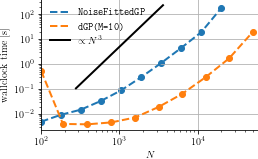

In [99]:
size = (3.9, 0.618 * 3.9) if save else (10,6)
fig, ax = plt.subplots(figsize=size)
ax.set_xscale("log")
ax.set_yscale("log")
ax.grid(True)
labels = [r"\texttt{NoiseFittedGP}",r"\texttt{dGP(M=10)}"]
for i,(name,gp) in enumerate(gps.items()):
    N = Ns[i]
    runtime = np.load(f"../data/{name}_predict_runtime.npy")
    ax.plot(N, runtime, label=labels[i], ls="dashed")
    ax.scatter(N, runtime, c=ax.lines[-1].get_color())
N = np.logspace(2,4,10)
ax.plot(N[2:-2], 1/2e8 * N[2:-2]**3, label=r"$\propto N^3$", c="k")
ax.set_xlabel(r"$N$")
ax.set_ylabel(r"wallclock time [s]")
ax.set_xlim([100,60000])
ax.legend(*ax.get_legend_handles_labels(), frameon=False, )
if save:
    fig.savefig(save_dir + f"gp_dgp_runtime.pdf",
                bbox_inches="tight",dpi=1000,pad_inches = 0.01)
else:
    plt.show()

## Consistency

In [89]:
dim = 5
sigma = .7
N_train = 700
X_train = LatinHypercube(dim).random(N_train)
y_train = noisy_friedman(X_train, sigma=sigma)
y_train_mean = np.mean(y_train)
y_train = y_train - y_train_mean

N_test = 700
X_test = LatinHypercube(dim).random(N_test)
y_test = noisy_friedman(X_test, sigma=sigma)
y_test = y_test - y_train_mean

In [90]:
sqexp = ConstantKernel(constant_value=1) * RBF(length_scale=[0.1])
coupling = ProjectionKernel(sqexp, P(dim, 0), tag="x0") * ProjectionKernel(sqexp, P(dim, 1), tag="x1")
sq_exp_c12_s3_i45 = coupling + ProjectionKernel(sqexp, P(dim, 2), tag="x3") \
                             + ProjectionKernel(sqexp, P(dim, 3), tag="x4") \
                             + ProjectionKernel(sqexp, P(dim, 4), tag="x5")

In [91]:
warnings.filterwarnings(action='ignore', category=ConvergenceWarning)
hyperparameters = {
    "n_restarts_optimizer": 9
}
dgp = DistributedGaussianProcessRegressor(kernel=sq_exp_c12_s3_i45, M=10, **hyperparameters)
prediction_error, prediction_error_std, trained_dgp = prediction_error_CV(squared_error, dgp, 
                                                                          X_train, y_train, 
                                                                          nfolds=10, return_best_predictor=True)
print(f"Trained kernel: {trained_dgp.kernel_}")
print(f"MSE = {prediction_error}")
print(f"MSE errors = {prediction_error_std}")

Trained kernel: ProjectionKernel(x0, 2.7**2 * RBF(length_scale=0.524)) * ProjectionKernel(x1, 2.7**2 * RBF(length_scale=0.519)) + ProjectionKernel(x3, 11.2**2 * RBF(length_scale=0.817)) + ProjectionKernel(x4, 21.2**2 * RBF(length_scale=3.1)) + ProjectionKernel(x5, 12.1**2 * RBF(length_scale=2.88)) + WhiteKernel(noise_level=0)
MSE = 0.5354814379860846
MSE errors = 0.09166633754217755


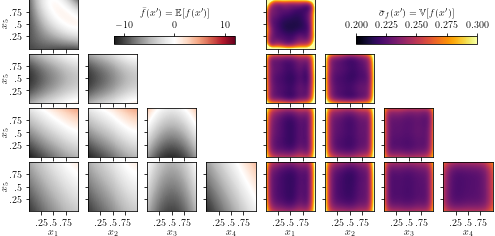

In [98]:
M = 100
dim = 5
fig, ax = plt.subplots(nrows=dim - 1, ncols=2 * (dim - 1), figsize=(8.4,3.9), 
                       sharex=True, sharey=True)
planes = list(combinations(np.arange(5),2))
x_cross=0.25
    
sigma_min = 0.2
sigma_max = 0.3

fmax = np.max(y_train)
fmin = np.min(y_train)
halfrange=max(np.abs(fmin), np.abs(fmax))

def my_formatter(x, pos):
    val_str = '{:g}'.format(x)
    if np.abs(x) > 0 and np.abs(x) < 1:
        return val_str.replace("0", "", 1)
    else:
        return val_str
major_formatter = FuncFormatter(my_formatter)

for plane_coordinates in planes:
    x = np.linspace(np.min(X_test[:,plane_coordinates[0]]),np.max(X_test[:,plane_coordinates[0]]),M)
    y = np.linspace(np.min(X_test[:,plane_coordinates[1]]),np.max(X_test[:,plane_coordinates[1]]),M)
    
    xx, yy = np.meshgrid(x,y)
    X = x_cross * np.ones((M*M,dim))
    X[:,plane_coordinates[0]] = xx.flatten()
    X[:,plane_coordinates[1]] = yy.flatten()
    f, sigma_f = trained_dgp.predict(X, return_std=True)
    f = f.reshape(M,M)
    sigma_f = sigma_f.reshape(M,M)
    
    i, j = plane_coordinates[1] - 1, plane_coordinates[0]

    ax[i,j].grid(False)
    ax[i,j].set_box_aspect(1)
    ax[i,dim - 1 + j].grid(False)
    ax[i,dim - 1 + j].set_box_aspect(1)
    
    im = ax[i,j].pcolormesh(xx,yy,f, cmap="RdGy_r", 
                            norm=colors.CenteredNorm(halfrange=halfrange),
                            rasterized=True)
    im2 = ax[i, dim-1+j].pcolormesh(xx,yy,np.sqrt(sigma_f), cmap="inferno", 
                                    vmin=sigma_min, vmax=sigma_max,
                                    rasterized=True)
    
    for a in [ax[:,:dim-1], ax[:, dim-1:]]:
        a[i,j].yaxis.set_ticks(np.arange(0.25, 1, 0.25))
        a[i,j].yaxis.set_major_formatter(major_formatter)
        a[i,j].xaxis.set_ticks(np.arange(0.25, 1, 0.25))
        a[i,j].xaxis.set_major_formatter(major_formatter)
    
ax[0,0].set_xlim([0,1])
ax[0,0].set_ylim([0,1])

for j in range(dim-1):
    ax[-1,j].set_xlabel(rf"$x_{j+1}$", color="k")
    ax[j,0].set_ylabel(rf"$x_{i+2}$", color="k")
    ax[-1,j].xaxis.labelpad=0
    ax[-1,dim-1+j].set_xlabel(rf"$x_{j+1}$", color="k")
    ax[-1,dim-1+j].xaxis.labelpad=0
    ax[j,0].yaxis.labelpad=0
    
for a in [ax[:,:dim-1], ax[:, dim-1:]]:
    for aa in a[np.triu_indices(dim - 1, 1)]:
        aa.axis('off')
    
plt.subplots_adjust(wspace=0.1, hspace=0.1)

cbar_ax = fig.add_axes([0.27, 0.72, 0.2, 0.03])
cbar_ax2 = fig.add_axes([0.67, 0.72, 0.2, 0.03])
label = [r"$\bar f(x') = \mathbb{E}[f(x')]$", r"$\bar \sigma_f(x')=\mathbb{V}[f(x')]$"]
ims = [im, im2]
for cbar_a,l,im in zip([cbar_ax, cbar_ax2],label, ims):
    cbar_a.grid(False)
    cbar = fig.colorbar(im, cax=cbar_a, orientation="horizontal")
    cbar.set_label(l)
    cbar.ax.xaxis.set_label_position('top') 
    cbar.ax.xaxis.tick_top()

if save:
    fig.savefig(save_dir + f"friedman_crossections_dgp_x_{x_cross:.2f}.pdf",
                bbox_inches="tight",dpi=1000,pad_inches = 0.01)
else:
    plt.show()